In [1]:
from function import *

/home/wmbio/anaconda3/envs/deepdep_paper/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wmbio/anaconda3/envs/deepdep_paper/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wmbio/anaconda3/envs/deepdep_paper/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wmbio/anaconda3/envs/d

In [2]:
print(os.getcwd())
os.chdir("/home/wmbio/WORK/gitworking/Dependency_prediction/")
print(os.getcwd())

/home/wmbio/WORK/gitworking/Dependency_prediction/prediction/src
/home/wmbio/WORK/gitworking/Dependency_prediction


## **Data Load & Path**

In [3]:
TRAIN_PATH = "/home/wmbio/WORK/gitworking/Dependency_prediction/preprocessing/DATA/2022-07-28/"
TEMP_PATH = "prediction/train_preprocessing/"
SAVE_PATH = "prediction/custom_model/"
CHECK_PATH = SAVE_PATH + "checkpoint/"
PREMODEL_PATH = "prediction/data/premodel_tcga/"

* **All Omics**

In [4]:
data_exp, data_mut, data_cna, data_meth, data_fprint, data_dep = trainset_load()
gc.collect()

# paper
# with open('prediction/data/paper/ccl_complete_data_278CCL_1298DepOI_360844samples.pickle', 'rb') as f:
#     data_mut, data_exp, data_cna, data_meth, data_dep, data_fprint = pickle.load(f)

0

## **Build Model**

* **Pretrained Model load - TCGA**

In [5]:
premodel_mut = pickle.load(open(PREMODEL_PATH + 'premodel_tcga_mut_1000_100_50.pickle', 'rb'))
premodel_exp = pickle.load(open(PREMODEL_PATH + 'premodel_tcga_exp_500_200_50.pickle', 'rb'))
premodel_cna = pickle.load(open(PREMODEL_PATH + 'premodel_tcga_cna_500_200_50.pickle', 'rb'))
premodel_meth = pickle.load(open(PREMODEL_PATH + 'premodel_tcga_meth_500_200_50.pickle', 'rb'))
print("\n\nDatasets successfully loaded.")



Datasets successfully loaded.


* **Golbal variable**

In [6]:
batch_size = 500
num_epoch = 100
num_DepOI = 1298 # 1298 DepOIs as defined in our paper, custom 1227
num_ccl = int(data_exp.shape[0]/num_DepOI)
split_ratio = 0.7

* **Train / Test split**

In [7]:
# 80% CCLs for training/validation, and 20% for testing
id_rand = np.random.permutation(num_ccl)
id_cell_train = id_rand[np.arange(0, round(num_ccl * split_ratio))]
id_cell_test = id_rand[np.arange(round(num_ccl * split_ratio), num_ccl)]
id_train = np.arange(0, num_DepOI) + id_cell_train[0]*num_DepOI
for y in id_cell_train:
    id_train = np.union1d(id_train, np.arange(0, num_DepOI) + y*num_DepOI)
id_test = np.arange(0, num_DepOI) + id_cell_test[0] * num_DepOI
for y in id_cell_test:
    id_test = np.union1d(id_test, np.arange(0, num_DepOI) + y*num_DepOI)
print("\n\nTraining/validation on %d samples (%d CCLs x %d DepOIs) and testing on %d samples (%d CCLs x %d DepOIs).\n\n" % (
    len(id_train), len(id_cell_train), num_DepOI, len(id_test), len(id_cell_test), num_DepOI))



Training/validation on 429638 samples (331 CCLs x 1298 DepOIs) and testing on 184316 samples (142 CCLs x 1298 DepOIs).




## **Fit & Evaluation Model**

### **(1) Full Model 4-Omics**

In [ ]:
with tf.device('/cpu:0'):
    K.clear_session()
    model = full_model(data_mut=data_mut, data_exp=data_exp, data_cna=data_cna,data_meth=data_meth,
                      data_fprint=data_fprint, data_dep=data_dep, id_train=id_train, id_test=id_test,
                      premodel_mut=premodel_mut, premodel_exp=premodel_exp, premodel_cna=premodel_cna,
                      premodel_meth=premodel_meth, save_path = CHECK_PATH)

In [ ]:
SAVE_NAME = "model_full_0801"
model[0].save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))

### **(2) Expression-Mutation-CNA Model**

In [ ]:
with tf.device('/cpu:0'):
    K.clear_session()
    model = mut_exp_cna_model(data_mut=data_mut, data_exp=data_exp, data_cna=data_cna,
                      data_fprint=data_fprint, data_dep=data_dep, id_train=id_train, id_test=id_test,
                      premodel_mut=premodel_mut, premodel_exp=premodel_exp, premodel_cna=premodel_cna,
                      save_path = CHECK_PATH)

In [ ]:
model_train_vis(history=model[1])

In [ ]:
SAVE_NAME = "model_mut_exp_cna_0801"
model[0].save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nMut_Exp_CNA-DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))

### **(3) Expression-Mutation Model**

In [ ]:
with tf.device('/cpu:0'):
    K.clear_session()
    model = mut_exp_model(data_mut=data_mut, data_exp=data_exp, 
                      data_fprint=data_fprint, data_dep=data_dep, id_train=id_train, id_test=id_test,
                      premodel_mut=premodel_mut, premodel_exp=premodel_exp,
                      save_path = CHECK_PATH)

In [ ]:
model_train_vis(history=model[1])

In [ ]:
SAVE_NAME = "model_mut_exp_0801"
model[0].save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nMut_CNA-DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))

### **(4) Expression Model**

In [8]:
with tf.device('/cpu:0'):
    K.clear_session()
    model = exp_model(data_exp=data_exp, data_fprint=data_fprint, data_dep=data_dep, 
                      id_train=id_train, id_test=id_test, premodel_exp=premodel_exp,
                      save_path = CHECK_PATH)

Train on 334162 samples, validate on 95476 samples
Epoch 1/30
334162/334162 [==============================] - 78s - loss: 0.0865 - val_loss: 0.0638
Epoch 2/30
334162/334162 [==============================] - 72s - loss: 0.0593 - val_loss: 0.0614
Epoch 3/30
334162/334162 [==============================] - 72s - loss: 0.0578 - val_loss: 0.0609
Epoch 4/30
334162/334162 [==============================] - 72s - loss: 0.0567 - val_loss: 0.0599
Epoch 5/30
334162/334162 [==============================] - 71s - loss: 0.0559 - val_loss: 0.0606
Epoch 6/30
334162/334162 [==============================] - 71s - loss: 0.0553 - val_loss: 0.0596
Epoch 7/30
334162/334162 [==============================] - 71s - loss: 0.0548 - val_loss: 0.0593
Epoch 8/30
334162/334162 [==============================] - 71s - loss: 0.0543 - val_loss: 0.0600
Epoch 9/30
334162/334162 [==============================] - 71s - loss: 0.0540 - val_loss: 0.0599
Epoch 10/30
334162/334162 [==============================] - 71s - 

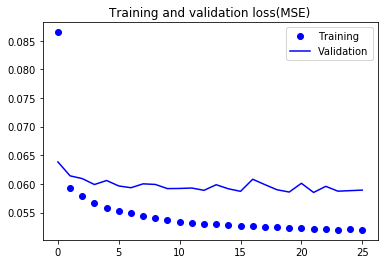

In [9]:
model_train_vis(history=model[1])

In [10]:
SAVE_NAME = "model_exp_0801"
model[0].save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\Exp-DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))


\Exp-DeepDEP model saved in prediction/custom_model/model_exp_0801.h5




### **(5) Mutation Model**

In [14]:
with tf.device('/cpu:0'):
    K.clear_session()
    model = mut_model(data_mut=data_mut, data_fprint=data_fprint, data_dep=data_dep, 
                      id_train=id_train, id_test=id_test, premodel_mut=premodel_mut,
                      save_path = CHECK_PATH)

Train on 334162 samples, validate on 95476 samples
Epoch 1/30
334162/334162 [==============================] - 49s - loss: 0.0703 - val_loss: 0.0816
Epoch 2/30
334162/334162 [==============================] - 49s - loss: 0.0579 - val_loss: 0.0914
Epoch 3/30
334162/334162 [==============================] - 49s - loss: 0.0556 - val_loss: 0.0727
Epoch 4/30
334162/334162 [==============================] - 48s - loss: 0.0544 - val_loss: 0.1004
Epoch 5/30
334162/334162 [==============================] - 49s - loss: 0.0533 - val_loss: 0.0906
Epoch 6/30
334162/334162 [==============================] - 49s - loss: 0.0519 - val_loss: 0.0703
Epoch 7/30
334162/334162 [==============================] - 49s - loss: 0.0508 - val_loss: 0.0897
Epoch 8/30
334162/334162 [==============================] - 48s - loss: 0.0502 - val_loss: 0.0897
Epoch 9/30
334162/334162 [==============================] - 49s - loss: 0.0496 - val_loss: 0.0934
Epoch 10/30
334162/334162 [==============================] - 49s - 

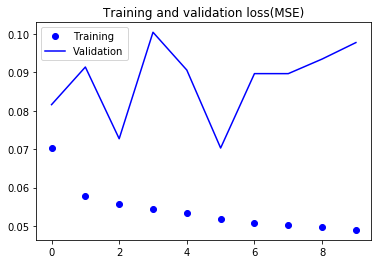

In [15]:
model_train_vis(history=model[1])

In [16]:
SAVE_NAME = "model_mut_0801"
model[0].save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))



Full DeepDEP model saved in prediction/custom_model/model_mut_0801.h5




### **(6) CNA Model**

In [ ]:
with tf.device('/cpu:0'):
    K.clear_session()
    model = cna_model(data_cna=data_cna, data_fprint=data_fprint, data_dep=data_dep, 
                      id_train=id_train, id_test=id_test, premodel_cna=premodel_cna,
                      save_path = CHECK_PATH)

Train on 334162 samples, validate on 95476 samples
Epoch 1/30
334162/334162 [==============================] - 50s - loss: 2.7889 - val_loss: 0.0655
Epoch 2/30
334162/334162 [==============================] - 50s - loss: 0.0617 - val_loss: 0.0635
Epoch 3/30
334162/334162 [==============================] - 50s - loss: 0.0606 - val_loss: 0.0633
Epoch 4/30
334162/334162 [==============================] - 51s - loss: 0.0600 - val_loss: 0.0625
Epoch 5/30
334162/334162 [==============================] - 51s - loss: 0.0596 - val_loss: 0.0618
Epoch 6/30
334162/334162 [==============================] - 50s - loss: 0.0594 - val_loss: 0.0636
Epoch 7/30
334162/334162 [==============================] - 50s - loss: 0.0594 - val_loss: 0.0646
Epoch 8/30
334162/334162 [==============================] - 50s - loss: 0.0589 - val_loss: 0.0634
Epoch 9/30
334162/334162 [==============================] - 50s - loss: 0.0592 - val_loss: 0.0636


In [ ]:
model_train_vis(history=model[1])

In [ ]:
SAVE_NAME = "model_cna_0801"
model[0].save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))

### **(7) Meth Model**

In [ ]:
with tf.device('/cpu:0'):
    K.clear_session()
    model = meth_model(data_meth=data_meth, data_fprint=data_fprint, data_dep=data_dep, 
                      id_train=id_train, id_test=id_test, premodel_meth=premodel_meth,
                      save_path = CHECK_PATH)

In [ ]:
model_train_vis(history=model[1])

In [ ]:
SAVE_NAME = "model_cna_0801"
model[0].save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))